In [94]:
# Import the necessary packages
import tensorflow as tf
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras import backend as K
import os
import keras
from random import randint,random
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
import pandas as pd
from keras.models import Model
from keras import layers
import tensorflow as tf
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications import inception_v3, resnet, mobilenet, vgg16, vgg19, xception
from numpy import genfromtxt
import PIL
%matplotlib inline
K.set_image_data_format('channels_last')

In [95]:
# Load the ResNet model
target_shape = (224, 224)
target_size = (224, 224)
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=(224,224) + (3,), include_top=False
)
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [96]:
# Define the distance layer
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [97]:
# Define the Siamese network    
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [98]:
# Define the Siamese model class for training
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [99]:
# Define the floder paths
folder_path = "lfw-deepfunneled"
subfolders = [x[0] for x in os.walk(folder_path)]
subfolders = subfolders[1:]

In [100]:
# Define the image paths
people = []
for i in range(len(subfolders)):
    image_count = len([f for f in os.listdir(subfolders[i]) if os.path.isfile(os.path.join(subfolders[i], f))])
    if image_count >= 1:
        people.append([subfolders[i].split("\\")[-1], image_count])

people = sorted(people, key=lambda x: x[1], reverse=True)

In [101]:
# Check the data
print("Number of people with atleast 1 image: ", len(people))
print("Number of images: ", sum([x[1] for x in people]))
print("Number of people with atleast 2 images: ", len([x for x in people if x[1] >= 2]))


Number of people with atleast 1 image:  5749
Number of images:  13233
Number of people with atleast 2 images:  1680


In [102]:
# Select the people with atleast 5 images
selected_people = [x[0] for x in people if x[1] >= 5]
print("Number of people with atleast 5 images: ", len(selected_people))
selected_people_images = [[x,os.listdir(folder_path + "\\" + x)[0:5]] for x in selected_people]
selected_people_images[0]

Number of people with atleast 5 images:  423


['George_W_Bush',
 ['George_W_Bush_0001.jpg',
  'George_W_Bush_0002.jpg',
  'George_W_Bush_0003.jpg',
  'George_W_Bush_0004.jpg',
  'George_W_Bush_0005.jpg']]

In [103]:
# Make the triplets
triplets = []
for index,[person,images] in enumerate(selected_people_images):
    for i in range(4):
        for j in range(i+1,5):
            anchor = images[i]
            positive = images[j]
            random_class = index
            while random_class == index:
                random_class = randint(0, len(selected_people_images)-1)            
            random_image = randint(0, 4)
            negative_person = selected_people_images[random_class][0]
            negative = selected_people_images[random_class][1][random_image]
            triplets.append([folder_path+"\\"+person+"\\"+anchor, folder_path+"\\"+person+"\\"+positive, folder_path+"\\"+negative_person+"\\"+negative])

In [104]:
# Function to preprocess the image
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

In [105]:
# Function to plot the images
def plot_images(triplets,index):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7,12))
    axis = fig.subplots(10, 3)
    
    for i in range(0,index):
        anchor,positive,negative = triplets[index+i]
        show(axis[i,0], preprocess_image(anchor))
        show(axis[i,1], preprocess_image(positive))
        show(axis[i,2], preprocess_image(negative))

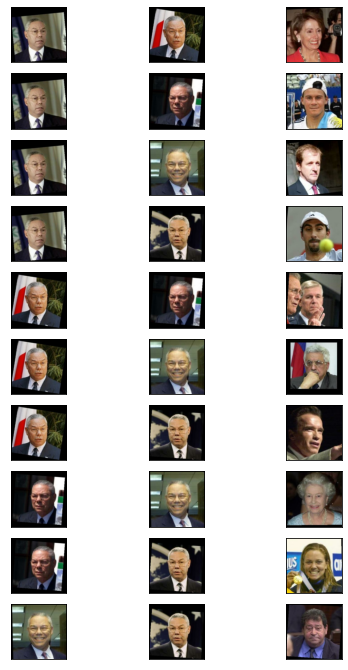

In [106]:
# Test the plot function
plot_images(triplets,10)

In [107]:
# Function to preprocess the triplets
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [108]:
# Shuffle the triplets
np.random.shuffle(triplets)

# Load the triplets into the dataset object and preprocess them
anchor_images = [a[0] for a in triplets]
positive_images = [a[1] for a in triplets]
negative_images = [a[2] for a in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [109]:
# Split the dataset into training and validation
training_data = dataset.take(round(image_count * 0.8))
validation_data = dataset.skip(round(image_count * 0.8))

training_data = training_data.batch(32, drop_remainder=False)
training_data = training_data.prefetch(64)

validation_data = validation_data.batch(32, drop_remainder=False)
validation_data = validation_data.prefetch(64)

In [110]:
# Train the model
import time
start = time.time()
epochs = 15
model = SiameseModel(siamese_network)
model.compile(optimizer=keras.optimizers.Adam(0.0001),weighted_metrics=[])
model.built = True
model.load_weights('siamese_network_weights.h5')
history = model.fit(training_data, epochs=epochs, validation_data=validation_data)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/15
1/1 [==============================] - 117s 117s/step - loss: 0.0000e+00 - val_loss: 0.7560
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 3.4844

KeyboardInterrupt: 

In [ ]:
# Save the model's weights
import json
model.save_weights("siamese_network_weights.h5")
config = model.to_json()
with open("siamese_network_config.json", "w") as json_file:
    json.dump(config, json_file)

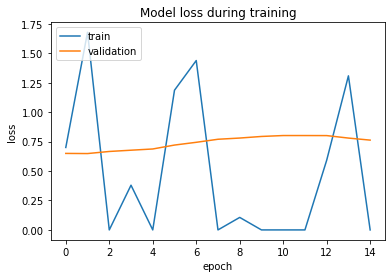

In [ ]:
# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Retrieve a datapoint from the dataset
sample = next(iter(training_data))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(inputs = resnet.preprocess_input(anchor)),
                                                            embedding(inputs = resnet.preprocess_input(positive)), 
                                                            embedding(inputs = resnet.preprocess_input(negative)))


In [ ]:
# Calculate the distance between the anchor and its positive and negative images
d1 = np. sum(np. power((anchor_embedding-positive_embedding),2))
print(f'Anchor-positive difference = {d1}')

d2 = np. sum(np. power((anchor_embedding-negative_embedding),2))
print(f'Anchor-negative difference = {d2}')

Anchor-positive difference = 0.6208581924438477
Anchor-negative difference = 0.9465698003768921


In [ ]:
# Calculate the cosine similarity between the anchor and its positive and negative images
cosine_similarity = keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9994695
Negative similarity 0.99933326


In [ ]:
# Function to calculate the embedding of an image
def image_to_embedding(image_path, model):
   img = preprocess_image(image_path)
   img = tf.expand_dims(img, axis=0)
   embedding_ = embedding.predict(img)
   return embedding_

In [ ]:
# Store the embeddings of the images in the database
start = time.time()
database = {}
for person in os.listdir(folder_path):
    database[person] = image_to_embedding(folder_path+"\\"+person+"\\"+os.listdir(folder_path+"\\"+person)[0], embedding).tolist()
stop = time.time()
print(f'Embedding the database took: {(stop-start)/60} minutes')

1/1 [==============================] - 0s 30ms/step
Embedding the database took: 9.284538300832113 minutes


In [ ]:
import json
with open("embeddings.json", "w") as outfile:
    json.dump(database, outfile)

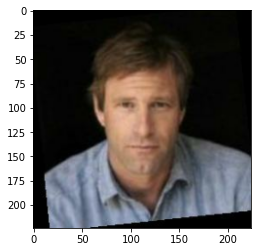

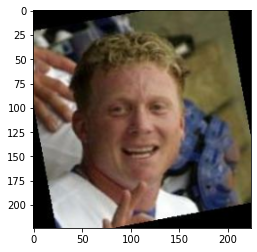

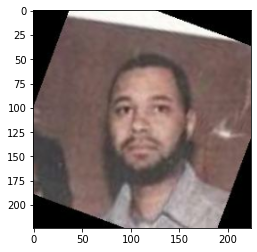

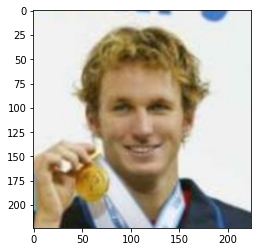

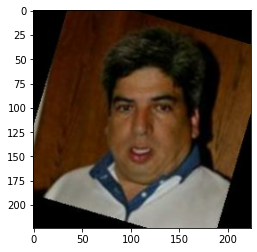

In [ ]:
# Show the the first 5 images in the database
persons = list(database.keys())
for person in persons[0:5]:
    plt.imshow(preprocess_image(folder_path+"\\"+person+"\\"+os.listdir(folder_path+"\\"+person)[0]))
    plt.show()

In [ ]:
# Function to verify the identity of a person
def verify(image_path,identity,database,model):
    encoding = image_to_embedding(image_path,model)
    dist = np.linalg.norm(encoding-np.array(database[identity]))
    if dist<1:
        print("Verified! It's " + str(identity))
    else:
        print("Not verified! It's not " + str(identity))
    return dist

In [ ]:
def recognise(image_path,database,model):
    encoding = image_to_embedding(image_path,model)
    min_dist = 100
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding-np.array(db_enc))
        if dist<min_dist:
            min_dist = dist
            identity = name
        print("distance for "+str(name)+" is "+str(dist))
    if min_dist>1:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
    return min_dist, identity

In [ ]:
for i in range(5):
    print(people[i][0])

George_W_Bush
Colin_Powell
Tony_Blair
Donald_Rumsfeld
Gerhard_Schroeder


1/1 [==============================] - 0s 39ms/step
Verified! It's Donald_Rumsfeld
Distance between the images: 0.9576931973404499


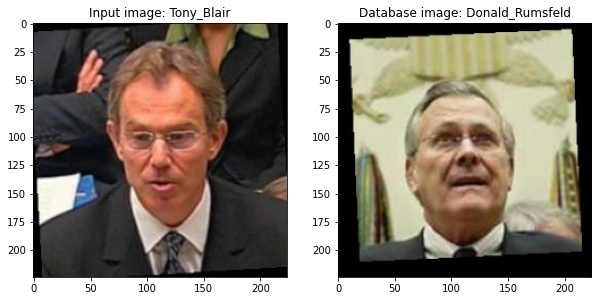

In [ ]:
# Verify the identity of a person
target = "Tony_Blair"
identity = "Donald_Rumsfeld"
num = randint(1, 5)
image_path = f"{folder_path}\\{target}\\{target}_000{num}.jpg"
dist = verify(image_path,identity, database,  embedding)
print(f"Distance between the images: {dist}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(preprocess_image(image_path))
ax[0].set_title("Input image: " + target)
ax[1].imshow(preprocess_image(f"{folder_path}\\{identity}\\{identity}_0001.jpg"))
ax[1].set_title("Database image: " + identity)
plt.show()

1/1 [==============================] - 0s 28ms/step
distance for Aaron_Eckhart is 0.8845942364679171
distance for Aaron_Guiel is 0.7844766514117187
distance for Aaron_Patterson is 1.1623809415302158
distance for Aaron_Peirsol is 0.8049717494910942
distance for Aaron_Pena is 0.8661415568848904
distance for Aaron_Sorkin is 0.8008655581591299
distance for Aaron_Tippin is 0.9698476577916936
distance for Abbas_Kiarostami is 0.8752641902968622
distance for Abba_Eban is 0.7728361621986495
distance for Abdel_Aziz_Al-Hakim is 0.6498191960067449
distance for Abdel_Madi_Shabneh is 0.8930476789686292
distance for Abdel_Nasser_Assidi is 0.8575665324397519
distance for Abdoulaye_Wade is 1.4695569086911147
distance for Abdulaziz_Kamilov is 1.2666282398396902
distance for Abdullah is 0.8181194757633117
distance for Abdullah_Ahmad_Badawi is 1.038446588920934
distance for Abdullah_al-Attiyah is 1.5275156317356573
distance for Abdullah_Gul is 1.3789964427431984
distance for Abdullah_Nasseef is 0.67214618

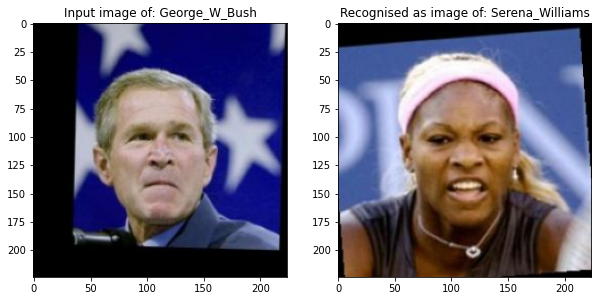

In [ ]:
target = "George_W_Bush"
num = randint(1,5)
image_path = f"{folder_path}\\{target}\\{target}_000{num}.jpg"
min_dist, identity = recognise(image_path, database, embedding)
print(f"Minimum distance between the images: {min_dist}")
if min_dist < 0.7:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(preprocess_image(image_path))
    ax[0].set_title("Input image of: " + target)
    ax[1].imshow(preprocess_image(f"{folder_path}\\{identity}\\{identity}_0001.jpg"))
    ax[1].set_title("Recognised as image of: " + identity)
    plt.show()